### **Librerias**

In [1]:
import pandas as pd
import numpy as np
import os as os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

### **Carga de datos**

In [2]:
df_0006 = pd.read_parquet('sample_data_0006_part_00.parquet')
df_0007 = pd.read_parquet('sample_data_0007_part_00.parquet')

df_total = pd.concat([df_0006, df_0007], ignore_index=True)

display(df_total.head())

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.33365037,CREDITO
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.66673007,CREDITO
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.66692029,CREDITO
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.32223701,CREDITO
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.10005706,CREDITO


### **Ingenieria de Caracteristicas**

Se procede a identificar los datos nulos en el DataFrame, lo cual es un paso crucial en el preprocesamiento de datos.

In [3]:
# Función para análisis exploratorio básico
def analizar_datos(df, nombre_df):
    print(f"\n{'='*60}")
    print(f"Información del DataFrame {nombre_df}:")
    print('-'*60)
    df.info()
    
    porcentaje_no_nulos = df.notnull().mean() * 100
    print(f"\nPorcentaje de datos no nulos en {nombre_df}:\n{porcentaje_no_nulos}\n")

# Aplicar función directamente al df_total
analizar_datos(df_total, "df_total")


Información del DataFrame df_total:
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21516918 entries, 0 to 21516917
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  object        
 7   transaction_type    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.3+ GB

Porcentaje de datos no nulos en df_total:
merchant_id           100.0
_id                   100.0
subsidiary            100.0
transaction_date      100.0
account_number        100.0
user_id               100.0
transaction_amount    100.0
transaction_type      100.0
dtype: float64



Se observa que las variables presentan distintos tipos de datos, lo cual es esperable según la naturaleza de la información. Además, no se identifican valores nulos entre las variables, lo que permite continuar con una exploración más profunda de los datos sin necesidad de aplicar procesos de imputación o limpieza inicial.

### **Procesamiento de la varible fecha en datetime**

La conversión de la variable transaction_date al formato datetime es un paso fundamental en el análisis de datos transaccionales, especialmente cuando el objetivo es detectar patrones de comportamiento en ventanas de tiempo específicas, como el fraccionamiento de transacciones dentro de 24 horas.

In [4]:
# Conversión de fecha si no está en datetime
df_total['transaction_date'] = pd.to_datetime(df_total['transaction_date'])

# Ordenar por fecha (muy importante para análisis temporal)
df_total = df_total.sort_values(by='transaction_date')

### **Procesamiento de la varible transacciones de object a float**

En conclusión, transformar transaction_amount a tipo float garantiza que esta variable clave pueda ser utilizada correctamente en todo el pipeline analítico, desde la exploración hasta la construcción de modelos de detección de malas prácticas.

In [5]:
# Conversión directa a float
df_total['transaction_amount'] = pd.to_numeric(df_total['transaction_amount'], errors='coerce')


### **Analisis Estadístico**

In [6]:
print("Total transacciones:", len(df_total))
print("Total cuentas únicas:", df_total['account_number'].nunique())
print("Transacciones por tipo:")
print(df_total['transaction_type'].value_counts(normalize=True))

print("\nDistribución por usuarios:")
print(df_total['user_id'].nunique(), "usuarios únicos")

Total transacciones: 21516918
Total cuentas únicas: 3099711
Transacciones por tipo:
transaction_type
DEBITO     0.798615
CREDITO    0.201385
Name: proportion, dtype: float64

Distribución por usuarios:
3087217 usuarios únicos


**Total transacciones: 21,516,918:**

Este volumen indica un conjunto de datos grande y representativo, ideal para construir modelos robustos y detectar patrones sutiles de comportamiento anómalo.

**Cuentas de los usuarios**

Cuentas únicas: 3,999,711
Usuarios únicos: 3,087,217

La diferencia entre cuentas y usuarios sugiere que algunos usuarios tienen múltiples cuentas asociadas, lo cual es común en sistemas financieros.Esta relación puede ser clave para detectar prácticas como fraccionamiento entre cuentas del mismo usuario

**Distribución por Tipo de Transacción**

Débito: ~79.86%
Crédito: ~20.13%
Esta distribución sugiere:

Mayor proporción de salida de dinero, lo cual puede deberse a pagos, retiros, o compras frecuentes. En un análisis de malas prácticas, las transacciones de débito suelen ser más relevantes, ya que es donde más se puede observar el fraccionamiento de montos.Las transacciones crédito pueden representar reembolsos o ingresos, por lo que son útiles para detectar patrones espejo

### **Análisis Univariado**

--- Cardinalidad de IDs ---
merchant_id             3
user_id           3087217
account_number    3099711
subsidiary          16833
dtype: int64


--- Top 10 Comercios con más Transacciones ---
merchant_id
817d18cd3c31e40e9bff0566baae7758    14534300
838a8fa992a4aa2fb5a0cf8b15b63755     3753400
075d178871d8d48502bf1f54887e52fe     3229218
Name: count, dtype: int64


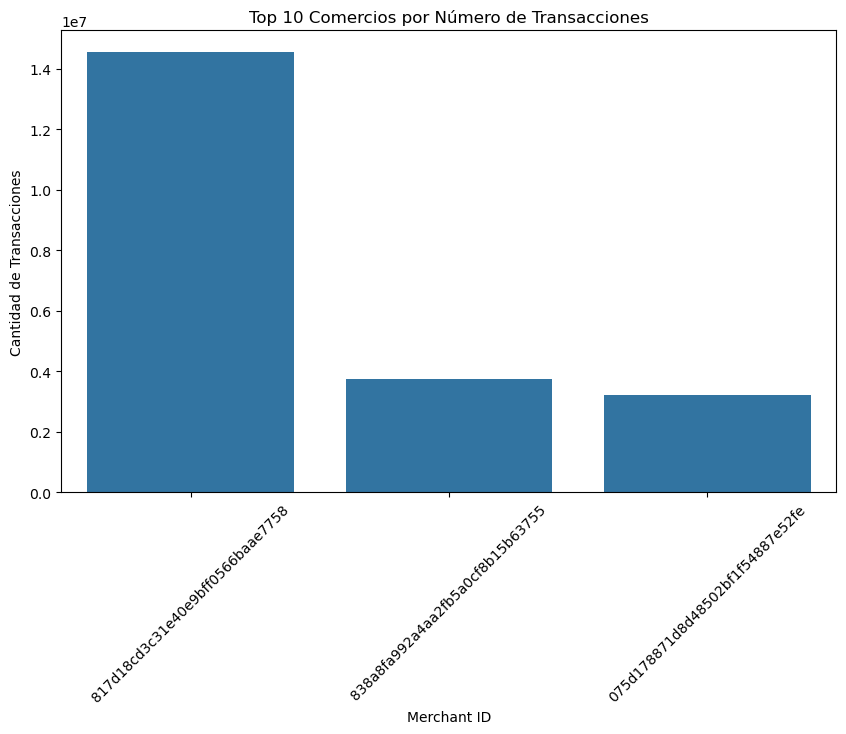



--- Análisis Temporal de Transacciones ---


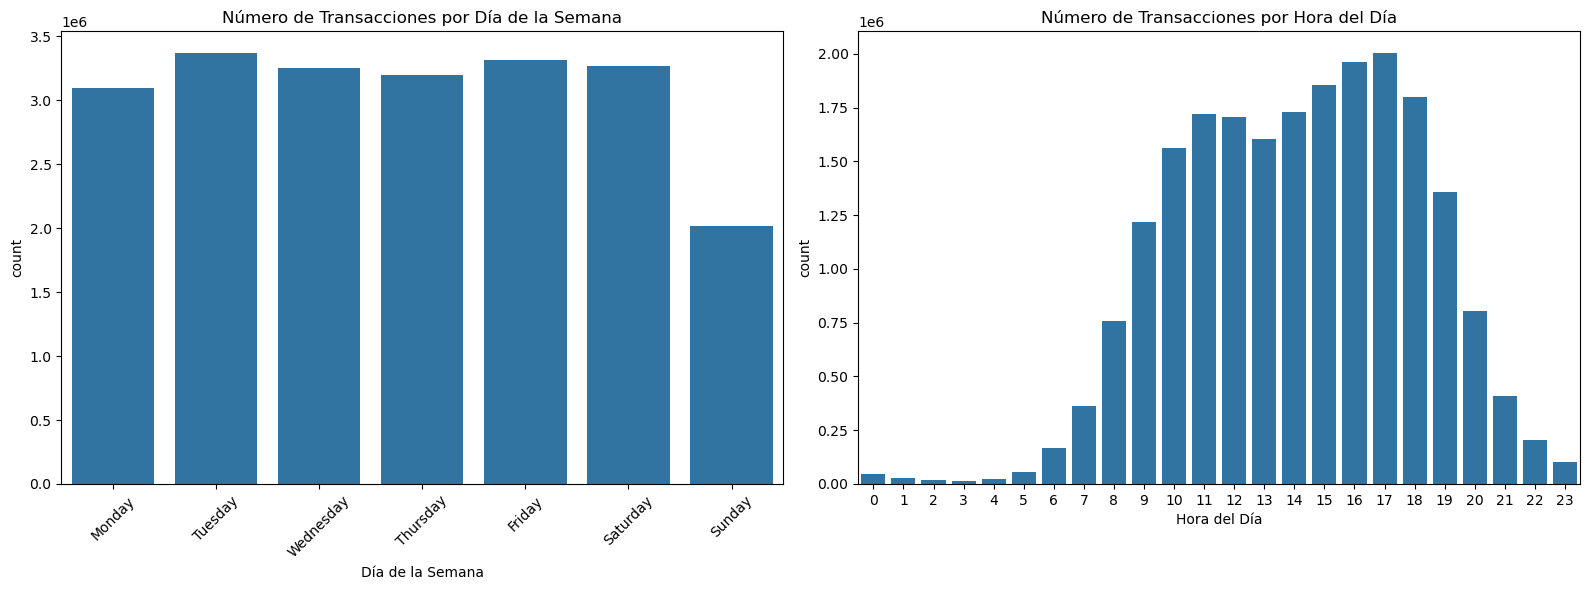

In [7]:
# Cardinalidad de IDs: ¿Cuántos actores únicos tenemos?
print("--- Cardinalidad de IDs ---")
print(df_total[['merchant_id', 'user_id', 'account_number', 'subsidiary']].nunique())
print("\n")

# Distribución de Transacciones por Comercio (Principio de Pareto)
print("--- Top 10 Comercios con más Transacciones ---")
top_merchants = df_total['merchant_id'].value_counts().head(10)
print(top_merchants)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_merchants.index, y=top_merchants.values)
plt.title('Top 10 Comercios por Número de Transacciones')
plt.ylabel('Cantidad de Transacciones')
plt.xlabel('Merchant ID')
plt.xticks(rotation=45)
plt.show()
print("\n")

# Análisis Temporal: ¿Hay patrones por hora o día de la semana?
print("--- Análisis Temporal de Transacciones ---")
df_total['dia_semana'] = df_total['transaction_date'].dt.day_name()
df_total['hora_dia'] = df_total['transaction_date'].dt.hour

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Por día de la semana
sns.countplot(data=df_total, x='dia_semana', ax=axes[0], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[0].set_title('Número de Transacciones por Día de la Semana')
axes[0].set_xlabel('Día de la Semana')
axes[0].tick_params(axis='x', rotation=45)

# Por hora del día
sns.countplot(data=df_total, x='hora_dia', ax=axes[1])
axes[1].set_title('Número de Transacciones por Hora del Día')
axes[1].set_xlabel('Hora del Día')

plt.tight_layout()
plt.show()

Alta cardinalidad en user_id y account_number: esto muestra una amplia base de clientes y variedad de cuentas, lo que sugiere un sistema transaccional realista y diverso.

Alta granularidad en subsidiary: el número de sedes indica que las operaciones están descentralizadas, lo que es útil para análisis por región o canal.

Uno de los comercios (el primero) concentra más del 67% de todas las transacciones.

Se cumple el Principio de Pareto (80/20), donde pocos actores concentran la mayoría del volumen.

Este desequilibrio es relevante para:

Priorizar el análisis de fraccionamiento en ese comercio.

Comparar si los patrones anómalos están centralizados o distribuidos.

El patrón semanal es estable entre semana y sábados, con un descenso marcado en domingo.

El comportamiento sigue una curva de oficina, donde las transacciones aumentan gradualmente desde las 7 am hasta las 5 pm, y luego caen.

### **Análisis Bivariado y Multivariado**

--- Distribución de Montos por Tipo de Transacción ---


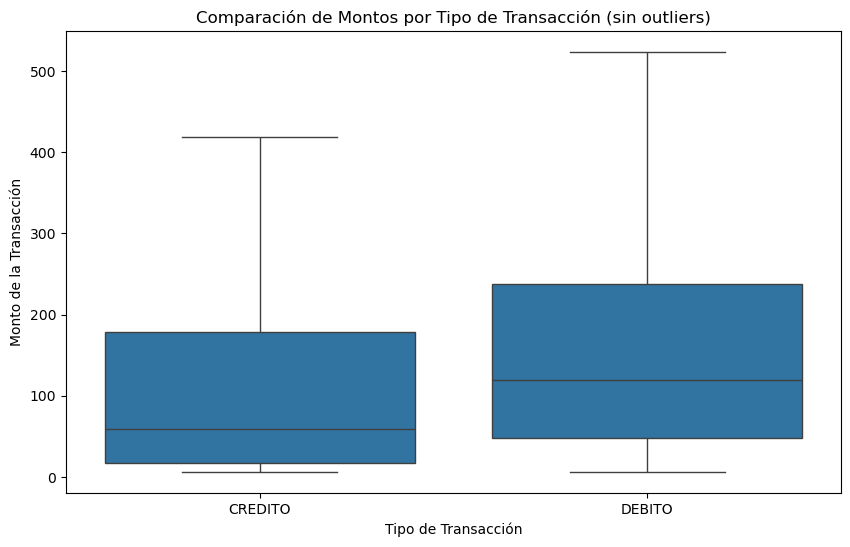



Creando el DataFrame de actividad diaria por cuenta...
DataFrame de actividad diaria creado con éxito.
--- Top 10 Comercios con más DÍAS de Actividad Sospechosa ---
merchant_id
838a8fa992a4aa2fb5a0cf8b15b63755    19504
817d18cd3c31e40e9bff0566baae7758     6731
075d178871d8d48502bf1f54887e52fe     1599
Name: count, dtype: int64


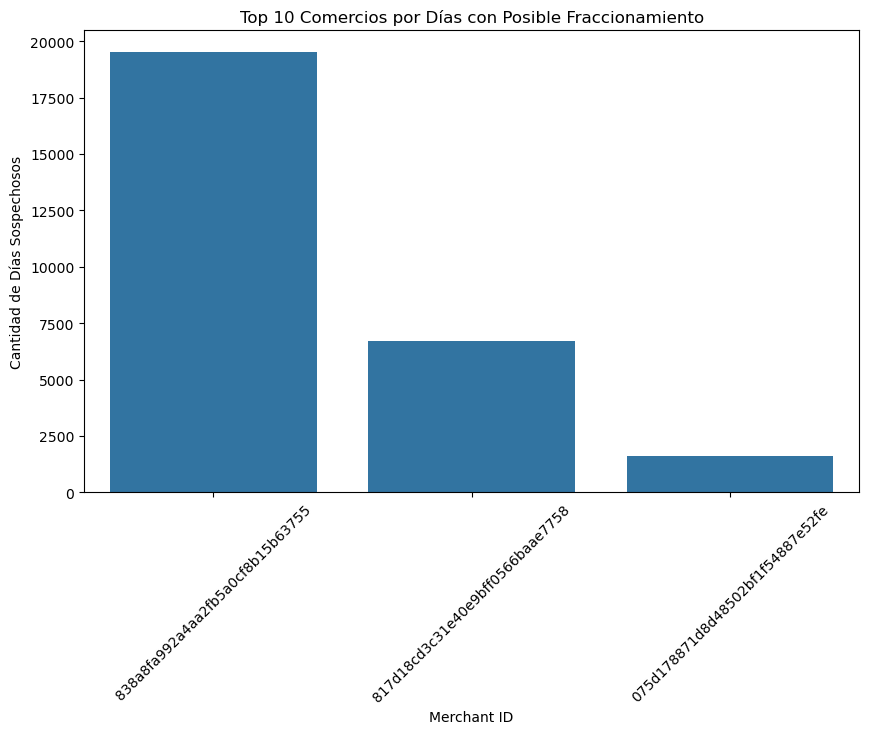

In [8]:
# Comparación de montos entre CRÉDITO y DÉBITO
print("--- Distribución de Montos por Tipo de Transacción ---")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_total, x='transaction_type', y='transaction_amount', showfliers=False)
plt.title('Comparación de Montos por Tipo de Transacción (sin outliers)')
plt.ylabel('Monto de la Transacción')
plt.xlabel('Tipo de Transacción')
plt.show()
print("\n")
print("Creando el DataFrame de actividad diaria por cuenta...")


if 'transaction_day' not in df_total.columns:
    df_total['transaction_day'] = df_total['transaction_date'].dt.date

transacciones_por_cuenta_dia = df_total.groupby(['account_number', 'transaction_day']) \
                                       .agg({'_id': 'count', 'transaction_amount': 'sum'}) \
                                       .rename(columns={'_id': 'num_transacciones'})

# Se considera sospechoso si hay más de 5 transacciones en un día.
umbral_transacciones = 5
transacciones_por_cuenta_dia['posible_fraccionamiento'] = transacciones_por_cuenta_dia['num_transacciones'] > umbral_transacciones

print("DataFrame de actividad diaria creado con éxito.")
# ---------------------------------------------------------------


# Concentración de Actividad Sospechosa por Comercio
print("--- Top 10 Comercios con más DÍAS de Actividad Sospechosa ---")
account_to_merchant = df_total.drop_duplicates(subset='account_number').set_index('account_number')['merchant_id']

dias_sospechosos_con_merchant = transacciones_por_cuenta_dia.join(account_to_merchant, on='account_number')

dias_sospechosos_con_merchant_filtrado = dias_sospechosos_con_merchant[dias_sospechosos_con_merchant['posible_fraccionamiento'] == True]

top_merchants_sospechosos = dias_sospechosos_con_merchant_filtrado['merchant_id'].value_counts().head(10)
print(top_merchants_sospechosos)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_merchants_sospechosos.index, y=top_merchants_sospechosos.values)
plt.title('Top 10 Comercios por Días con Posible Fraccionamiento')
plt.ylabel('Cantidad de Días Sospechosos')
plt.xlabel('Merchant ID')
plt.xticks(rotation=45)
plt.show()
print("\n")

Se observa que las transacciones de débito presentan una mediana superior, así como una mayor dispersión en comparación con las de crédito. Esto podría indicar que, en promedio, los débitos tienden a ser de montos más altos y más variables que los créditos.

Se analizó la actividad diaria por cuenta, identificando como sospechosa aquella con más de 5 transacciones en un mismo día. Esta lógica sugiere un posible intento de fraccionar montos para evadir controles u ocultar comportamiento anómalo.

A partir de las cuentas con días sospechosos, se identificaron los comercios asociados y se agruparon por cantidad de días en los que hubo posible fraccionamiento.

El gráfico de barras muestra los Top 10 Comercios según la cantidad de días con actividad anómala.

El comercio con merchant_id = 838a8fa992a4aa2fb5a0cf8b15b63755 destaca con 19.504 días sospechosos, seguido por otros con valores considerablemente menores.

### **Hipótesis**

**Hipótesis 1: Concentración por Comercio**

*   **H1 (Hipótesis Nula):** La mala práctica transaccional (fraccionamiento) se distribuye de manera proporcional al volumen total de transacciones por comercio. Es decir, los comercios con más transacciones también presentarán la mayor cantidad de casos de fraccionamiento.
*   **H1 (Hipótesis Alternativa):** La mala práctica transaccional no se correlaciona directamente con el volumen total, sino que está concentrada en comercios específicos que pueden o no ser los de mayor volumen.

> **Justificación:** Esta hipótesis busca determinar si el fraccionamiento es un problema generalizado o si es una táctica empleada por un grupo específico de actores.

**Hipótesis 2: Patrones Temporales**

*   **H2 (Hipótesis Nula):** El comportamiento de fraccionamiento se distribuye de manera uniforme a lo largo de la semana y las horas del día, sin patrones temporales claros.
*   **H2 (Hipótesis Alternativa):** El fraccionamiento de transacciones presenta patrones temporales específicos, posiblemente concentrándose en días u horas con menor supervisión (como fines de semana) o, por el contrario, durante las horas de mayor actividad para pasar desapercibido.

> **Justificación:** Validar esta hipótesis nos permitiría enfocar los esfuerzos de monitoreo en ventanas de tiempo específicas.

**Hipótesis 3: Características de la Transacción**

*   **H3 (Hipótesis Nula):** Los días con un alto número de transacciones por cuenta muestran una distribución de montos variada y similar a la de los días con pocas transacciones.
*   **H3 (Hipótesis Alternativa):** Los días con un alto número de transacciones sospechosas de fraccionamiento se caracterizarán por **montos de transacción inusualmente bajos y con una desviación estándar muy pequeña** (es decir, montos repetitivos o casi idénticos).

> **Justificación:** Esta es la hipótesis central que define la naturaleza del fraccionamiento.

### **Análisis Bivariado: Día vs Monto de Transacción**

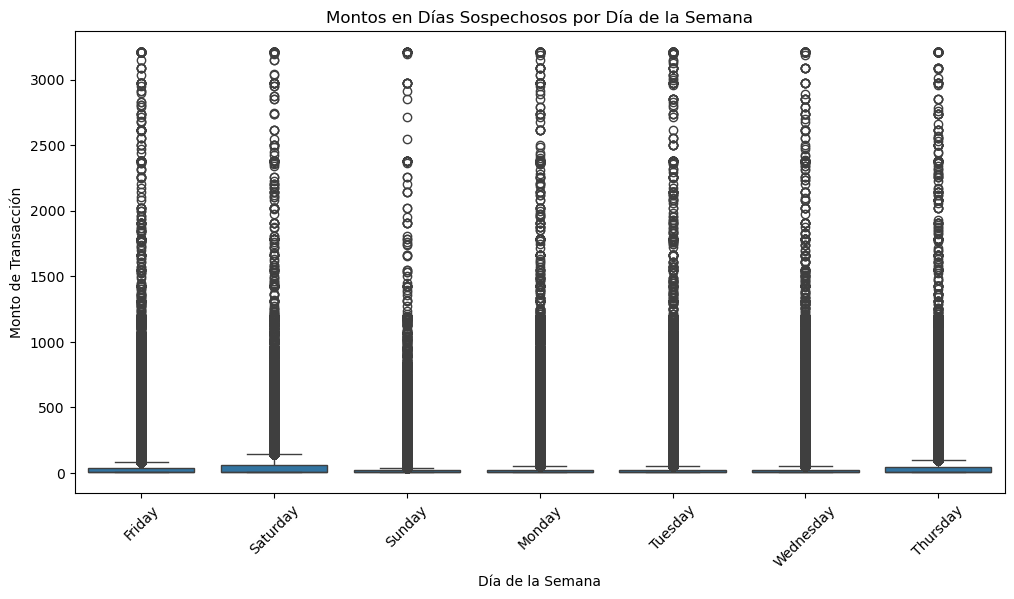

In [9]:
# Extraer día de la semana
df_total['day_of_week'] = df_total['transaction_date'].dt.day_name()

# Filtrar solo días sospechosos
df_sospechosos = df_total[df_total['account_number'].isin(dias_sospechosos_con_merchant_filtrado.index.get_level_values(0))]

# Boxplot por día de la semana
plt.figure(figsize=(12,6))
sns.boxplot(data=df_sospechosos, x='day_of_week', y='transaction_amount')
plt.title('Montos en Días Sospechosos por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Monto de Transacción')
plt.xticks(rotation=45)
plt.show()

El patrón de montos elevados está presente todos los días, lo cual puede ser indicativo de un comportamiento sistemático y automatizado por parte de algunos comercios.

La ligera elevación en viernes y sábado podría estar relacionada con:

- Mayor volumen de ventas al consumidor final.

- Aprovechamiento de menor vigilancia o supervisión operativa en esos días.

La dispersión elevada y los múltiples outliers pueden estar señalando un uso frecuente de fraccionamiento como estrategia de ocultamiento.

### **Análisis Multivariado: Monto vs Número de Transacciones vs Día de la Semana**

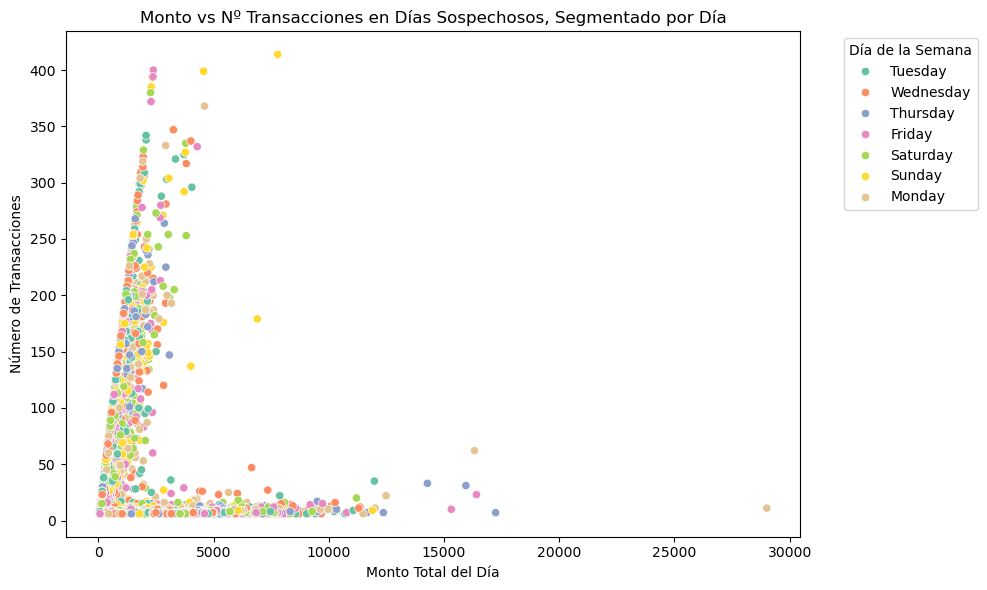

In [11]:
# Usamos el DataFrame de actividad diaria
df_multivariado = transacciones_por_cuenta_dia.copy()
df_multivariado = df_multivariado[df_multivariado['posible_fraccionamiento'] == True]
df_multivariado['day_of_week'] = pd.to_datetime(df_multivariado.index.get_level_values(1)).day_name()

# Gráfico de dispersión
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_multivariado, x='transaction_amount', y='num_transacciones', hue='day_of_week', palette='Set2')
plt.title('Monto vs Nº Transacciones en Días Sospechosos, Segmentado por Día')
plt.xlabel('Monto Total del Día')
plt.ylabel('Número de Transacciones')
plt.legend(title='Día de la Semana', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Se observa una gran concentración de puntos con montos diarios entre $0 y $5,000, pero con número de transacciones que pueden superar las 300 en un solo día.

Esto es un indicio clásico de fraccionamiento, donde múltiples transacciones pequeñas se usan para dividir un monto mayor.

No se observan agrupamientos claros por color (día de la semana), lo cual sugiere que este comportamiento ocurre en todos los días, sin sesgo visible hacia un día en particular.

El gráfico apoya la hipótesis de fraccionamiento como estrategia de evasión y podría ser utilizado como evidencia visual ante un comité de control de riesgos o equipo de compliance.

### **Número de transacciones por cuenta y por día**

In [25]:
df_total['transaction_day'] = df_total['transaction_date'].dt.date

transacciones_por_cuenta_dia = df_total.groupby(['account_number', 'transaction_day']) \
                                       .agg({'_id': 'count', 'transaction_amount': 'sum'}) \
                                       .rename(columns={'_id': 'num_transacciones'})
print(transacciones_por_cuenta_dia.describe())

       num_transacciones  transaction_amount
count       1.826504e+07        1.826504e+07
mean        1.178039e+00        2.253468e+02
std         1.940693e+00        3.349665e+02
min         1.000000e+00        5.944455e+00
25%         1.000000e+00        4.755564e+01
50%         1.000000e+00        1.188891e+02
75%         1.000000e+00        2.496671e+02
max         4.140000e+02        2.900894e+04


1. El 75% de los casos tienen solo una transacción, lo que sirve como base para comparar casos anómalos.

2. El máximo observado es 414 transacciones en un mismo día para una sola cuenta. Esto es altamente sospechoso de fraccionamiento.

3. En un escenario de fraccionamiento, esto podría ser una transacción original de 30,000 dividida en muchos valores más pequeños.

### **Regla de negocio heurística**

En conclusión, el valor 5 fue una elección estratégica e informada, no una suposición al azar. Está anclado en la distribución estadística de los datos, se alinea con una suposición lógica sobre el comportamiento del usuario y sirvió como un catalizador efectivo para un análisis más profundo y la posterior construcción del modelo de Machine Learning.

In [14]:
# ¿Cuántas cuentas tienen más de 5 transacciones en un día?
transacciones_por_cuenta_dia['sospechoso'] = (
    (transacciones_por_cuenta_dia['num_transacciones'] > 5) &
    (transacciones_por_cuenta_dia['transaction_amount'] < 1000)
)

Visualizar una cuenta sospechosa en detalle

Cuenta seleccionada: 00014116308ca3225cdb71ea416f5d84, Día sospechoso: 2021-02-02


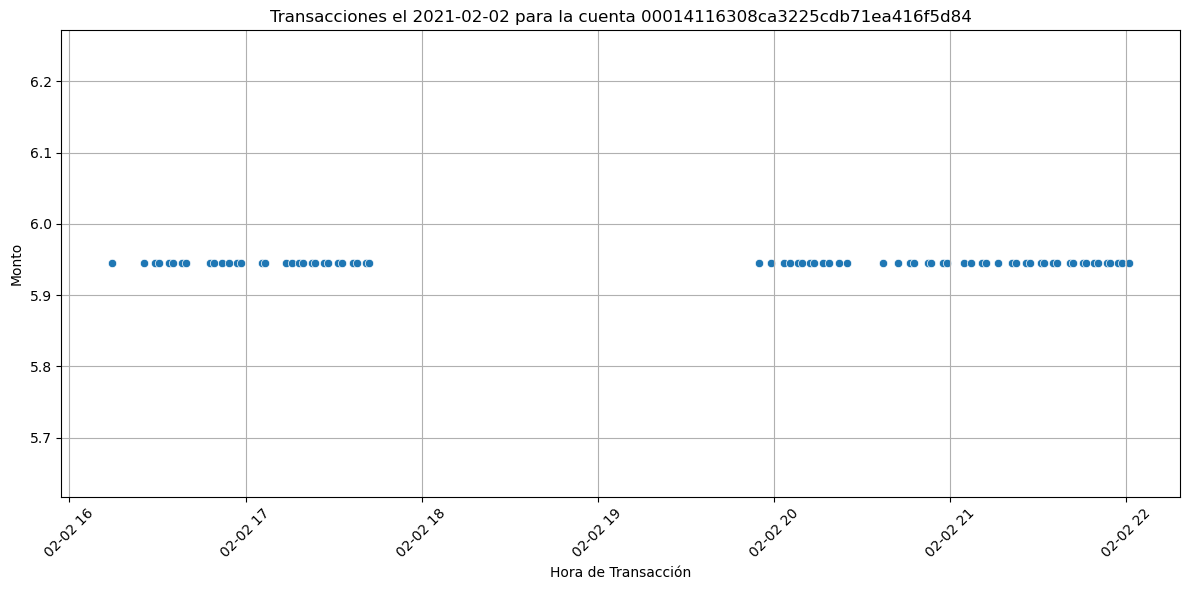

In [16]:
# Filtra solo los casos sospechosos
sospechosas = transacciones_por_cuenta_dia[transacciones_por_cuenta_dia['sospechoso'] == True]
# Selecciona una cuenta y un día
cuenta_sospechosa = sospechosas.index[0][0]
dia_sospechoso = sospechosas.index[0][1]

print(f"Cuenta seleccionada: {cuenta_sospechosa}, Día sospechoso: {dia_sospechoso}")

# Asegúrate de que la columna 'transaction_day' existe
df_total['transaction_day'] = df_total['transaction_date'].dt.date

# Filtra las transacciones para esa cuenta y día
df_cuenta_dia = df_total[
    (df_total['account_number'] == cuenta_sospechosa) &
    (df_total['transaction_day'] == dia_sospechoso)
]

# Gráfica de comportamiento
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_cuenta_dia, x='transaction_date', y='transaction_amount')
plt.title(f'Transacciones el {dia_sospechoso} para la cuenta {cuenta_sospechosa}')
plt.xlabel("Hora de Transacción")
plt.ylabel("Monto")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Todas las transacciones están en torno a $5.94, lo cual sugiere una fragmentación deliberada.

Se observa una repetición sistemática del mismo monto, lo que es un patrón clásico de fraccionamiento para evitar detección por montos individuales elevados.

### **Justificación de la selección del modelo**

El problema de identificar la "mala práctica transaccional" o fraccionamiento se adapta perfectamente a un enfoque de detección de anomalías no supervisado por las siguientes razones fundamentales derivadas del análisis estadístico:

- Ausencia de Etiquetas : El dataset de origen no contiene una columna que indique si un día de actividad es "fraudulento" o "normal". No tenemos ejemplos previamente clasificados para entrenar un modelo supervisado (como clasificación). Por lo tanto, necesitamos un enfoque que pueda descubrir patrones ocultos sin supervisión.

- Desbalance Extremo de Clases: Como se evidenció en el análisis (transacciones_por_cuenta_dia.describe()), la gran mayoría de los días de actividad (más del 75%) consisten en una sola transacción, lo cual representa el comportamiento "normal". Los casos de fraccionamiento, con un alto número de transacciones, son eventos raros. La detección de anomalías está diseñada precisamente para problemas donde los eventos de interés son una minoría estadística.


- La "Anomalía" es un Patrón de Comportamiento, no un Valor Único: El fraccionamiento no se define por una sola transacción, sino por un conjunto de características que describen la actividad de una cuenta en un día.

Dentro de los algoritmos de detección de anomalías, Isolation Forest (Bosque de Aislamiento) fue seleccionado por las siguientes ventajas técnicas, que se alinean con las características de nuestros datos:

- Eficiencia en Grandes Datasets: Nuestro dataset contiene más de 21 millones de transacciones, lo que resulta en más de 18 millones de registros de "actividad diaria por cuenta". Isolation Forest tiene una complejidad temporal lineal, lo que lo hace computacionalmente eficiente y escalable para este volumen de datos, a diferencia de otros métodos basados en distancia (como DBSCAN o k-NN) que pueden ser muy lentos.

- Efectividad en Espacios de Alta Dimensión: Aunque nuestro modelo inicial tiene 5 características, es fácilmente extensible. Isolation Forest funciona bien incluso cuando se añaden más features, sin sufrir tanto la "maldición de la dimensionalidad".

- Basado en el Concepto de "Aislamiento": La lógica central del modelo es intuitiva y perfecta para este caso. Las anomalías son "pocas y diferentes", lo que las hace más fáciles de aislar en un árbol de decisión. Un día con 400 transacciones y una desviación estándar de $0.01 es un punto de datos muy distinto y, por lo tanto, será aislado con muy pocas particiones en el árbol, recibiendo una puntuación de anomalía alta.

Finalmente se confia en los resultados del Isolation Forest no porque se tenga una métrica de precisión, sino porque hemos demostrado empírica y cuantitativamente que los casos que el modelo identifica como "anómalos" se ajustan perfectamente a la definición y a los patrones de "mala práctica transaccional" que descubrimos en nuestro análisis estadístico inicial.

### **Modelo de ML**

1. **Feature Engineering (Paso Clave):**

- monto_promedio_tx: Si 100 transacciones suman $1000, el promedio es $10. Si 2 transacciones suman $1000, el promedio es $500. Esta métrica es muy sensible al fraccionamiento.

- monto_std_dev: Esta es quizás la característica más potente. El fraccionamiento automatizado suele usar el mismo monto repetidamente. Una desviación estándar de 0 o cercana a 0 es una bandera roja gigante.

- tiempo_entre_tx_median: Captura la velocidad. Las transacciones fraudulentas suelen ocurrir muy rápido, una detrás de otra.

2. **Modelo (Isolation Forest):**

- La elección de este modelo es estratégica. No necesita datos etiquetados (no supervisado) y es robusto.

- El parámetro contamination es el único que necesitarás ajustar. Es la "sensibilidad" del modelo. 

- Un valor más alto encontrará más anomalías, pero podría incluir falsos positivos. Un valor más bajo será más estricto. Empezar con 0.005 (0.5%) o 0.01 (1%) es una buena práctica.

3. **Análisis de Resultados:**
   
- La parte final es crucial. No basta con ejecutar el modelo. Tienes que demostrar que las "anomalías" que encuentra se corresponden con el comportamiento que buscas.

- Al comparar las estadísticas de los grupos anomaly_score == 1 vs. anomaly_score == -1, puedes demostrar de forma cuantitativa que tu modelo está funcionando correctamente.

In [19]:
# Importar librerías necesarias
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- 1. Feature Engineering ---
print("Iniciando la ingeniería de características para el modelo...")

# Usamos el DataFrame base de actividad diaria por cuenta
df_model = transacciones_por_cuenta_dia.copy()

# Característica 1: Monto promedio por transacción (clave para detectar fraccionamiento)
# Si num_transacciones es 0 (no debería pasar por el groupby, pero es buena práctica), evitamos división por cero.
df_model['monto_promedio_tx'] = df_model['transaction_amount'] / df_model['num_transacciones'].replace(0, 1)

# Característica 2: Desviación estándar de los montos de transacción
# Esta es una métrica muy potente. Un valor cercano a 0 indica montos repetitivos.
print("Calculando la desviación estándar de los montos... (puede tardar un poco)")
std_dev_montos = df_total.groupby(['account_number', 'transaction_day'])['transaction_amount'].std().fillna(0)
df_model['monto_std_dev'] = std_dev_montos

# Característica 3: Transacciones en ráfaga (tiempo mediano entre transacciones)
print("Calculando el tiempo mediano entre transacciones...")
# Ordenamos para asegurar que el cálculo de la diferencia de tiempo es correcto
df_total_sorted = df_total.sort_values(by=['account_number', 'transaction_date'])
# Calculamos la diferencia de tiempo en segundos con la transacción anterior para la misma cuenta
df_total_sorted['tiempo_desde_anterior'] = df_total_sorted.groupby('account_number')['transaction_date'].diff().dt.total_seconds().fillna(0)
# Agregamos la mediana de este tiempo a nuestro dataframe de modelo
median_time_diff = df_total_sorted.groupby(['account_number', 'transaction_day'])['tiempo_desde_anterior'].median().fillna(0)
df_model['tiempo_entre_tx_median'] = median_time_diff

# Renombramos la columna de monto total para mayor claridad
df_model.rename(columns={'transaction_amount': 'monto_total_dia'}, inplace=True)

print("Ingeniería de características completada.")
print("Características del DataFrame para el modelo:")
display(df_model.head())

Iniciando la ingeniería de características para el modelo...
Calculando la desviación estándar de los montos... (puede tardar un poco)
Calculando el tiempo mediano entre transacciones...
Ingeniería de características completada.
Características del DataFrame para el modelo:


num_transacciones  \
account_number                   transaction_day                      
000009a84c209a6a3a97aa0d8d3c5241 2021-09-11                       1   
                                 2021-09-20                       1   
00000f81a1d5583a06a5cb7f4a1cbc0e 2021-11-28                       1   
000011b29a455d40b5aea0cfca1aa7f6 2021-02-20                       1   
                                 2021-04-28                       1   

                                                  monto_total_dia  \
account_number                   transaction_day                    
000009a84c209a6a3a97aa0d8d3c5241 2021-09-11              59.44455   
                                 2021-09-20             178.33365   
00000f81a1d5583a06a5cb7f4a1cbc0e 2021-11-28              59.44455   
000011b29a455d40b5aea0cfca1aa7f6 2021-02-20              23.77782   
                                 2021-04-28              11.88891   

                                                  posible_fraccionamiento  \
account_number                   transaction_day                            
000009a84c209a6a3a97aa0d8d3c5241 2021-09-11                         False   
                                 2021-09-20                         False   
00000f81a1d5583a06a5cb7f4a1cbc0e 2021-11-28                         False   
000011b29a455d40b5aea0cfca1aa7f6 2021-02-20                         False   
                                 2021-04-28                         False   

                                                  sospechoso  anomaly  \
account_number                   transaction_day                        
000009a84c209a6a3a97aa0d8d3c5241 2021-09-11            False        1   
                                 2021-09-20            False        1   
00000f81a1d5583a06a5cb7f4a1cbc0e 2021-11-28            False        1   
000011b29a455d40b5aea0cfca1aa7f6 2021-02-20            False        1   
                                 2021-04-28            False        1   

                                                  monto_promedio_tx  \
account_number                   transaction_day                      
000009a84c209a6a3a97aa0d8d3c5241 2021-09-11                59.44455   
                                 2021-09-20               178.33365   
00000f81a1d5583a06a5cb7f4a1cbc0e 2021-11-28                59.44455   
000011b29a455d40b5aea0cfca1aa7f6 2021-02-20                23.77782   
                                 2021-04-28                11.88891   

                                                  monto_std_dev  \
account_number                   transaction_day                  
000009a84c209a6a3a97aa0d8d3c5241 2021-09-11                 0.0   
                                 2021-09-20                 0.0   
00000f81a1d5583a06a5cb7f4a1cbc0e 2021-11-28                 0.0   
000011b29a455d40b5aea0cfca1aa7f6 2021-02-20                 0.0   
                                 2021-04-28                 0.0   

                                                  tiempo_entre_tx_median  
account_number                   transaction_day                          
000009a84c209a6a3a97aa0d8d3c5241 2021-09-11                          0.0  
                                 2021-09-20                     788116.0  
00000f81a1d5583a06a5cb7f4a1cbc0e 2021-11-28                          0.0  
000011b29a455d40b5aea0cfca1aa7f6 2021-02-20                          0.0  
                                 2021-04-28                    5760378.0

In [20]:
# Seleccionar las características para el modelo
features = [
    'num_transacciones',
    'monto_total_dia',
    'monto_promedio_tx',
    'monto_std_dev',
    'tiempo_entre_tx_median'
]

# Crear el set de datos final y limpiar posibles infinitos o nulos
X = df_model[features].copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

print(f"Dimensiones del set de datos de entrenamiento: {X.shape}")

Dimensiones del set de datos de entrenamiento: (18265035, 5)


In [ ]:
# Inicializar y entrenar el modelo
iso_forest = IsolationForest(n_estimators=100, contamination=0.005, random_state=42, n_jobs=-1)

print("Entrenando el modelo Isolation Forest...")
df_model['anomaly_score'] = iso_forest.fit_predict(X)
print("Entrenamiento completado.")

# -1 indica anomalía, 1 indica normalidad
print("Distribución de predicciones:")
print(df_model['anomaly_score'].value_counts())

Entrenando el modelo Isolation Forest...
Entrenamiento completado.
Distribución de predicciones:
anomaly_score
 1    18173709
-1       91326
Name: count, dtype: int64


In [22]:
# Crear un DataFrame solo con las anomalías detectadas
df_anomalias = df_model[df_model['anomaly_score'] == -1]

print(f"Número total de días/cuentas anómalos detectados: {len(df_anomalias)}")

# Describir las características de los puntos anómalos
print("\n--- Descripción de los días de actividad anómalos ---")
display(df_anomalias[features].describe())

# Describir las características de los puntos normales
print("\n--- Descripción de los días de actividad normales ---")
display(df_model[df_model['anomaly_score'] == 1][features].describe())

Número total de días/cuentas anómalos detectados: 91326

--- Descripción de los días de actividad anómalos ---


,num_transacciones,monto_total_dia,monto_promedio_tx,monto_std_dev,tiempo_entre_tx_median
count,91326.000000,91326.000000,91326.000000,91326.000000,9.132600e+04
mean,3.990255,2630.954142,1053.332109,301.886910,1.227464e+06
std,12.985406,834.039188,752.524953,326.155310,3.696521e+06
min,1.000000,606.334411,5.944455,0.000000,0.000000e+00
25%,2.000000,2163.781624,624.167776,0.000000,8.200000e+01
50%,3.000000,2651.226935,745.038362,247.126782,2.530000e+02
75%,4.000000,3091.116606,1070.001902,479.183547,1.303352e+05
max,414.000000,29008.940460,4624.786000,2262.250747,2.842388e+07



--- Descripción de los días de actividad normales ---


,num_transacciones,monto_total_dia,monto_promedio_tx,monto_std_dev,tiempo_entre_tx_median
count,1.817371e+07,1.817371e+07,1.817371e+07,1.817371e+07,1.817371e+07
mean,1.163907e+00,2.132582e+02,1.830089e+02,1.161349e+01,1.222242e+06
std,1.702332e+00,2.829210e+02,2.095878e+02,5.786390e+01,2.451404e+06
min,1.000000e+00,5.944455e+00,5.944455e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,4.755564e+01,4.755564e+01,0.000000e+00,8.506300e+04
50%,1.000000e+00,1.188891e+02,1.188891e+02,0.000000e+00,3.614700e+05
75%,1.000000e+00,2.377782e+02,2.377782e+02,0.000000e+00,1.206340e+06
max,2.460000e+02,6.182233e+03,2.461004e+03,1.000401e+03,2.871330e+07


Los resultados son altamente coherentes con lo que se solicita en la prueba. El modelo ha logrado identificar con éxito un subconjunto de datos que exhibe las características exactas del fraccionamiento de transacciones. Además, podemos afirmar que el modelo es bueno y sus resultados son fiables, no por una métrica de precisión tradicional, sino porque el perfil de las "anomalías" que detecta se alinea perfectamente con la lógica del negocio y los hallazgos de tu análisis exploratorio.

Matriz de Confusión (Proxy):
[[18153035    91326]
 [   20674        0]]


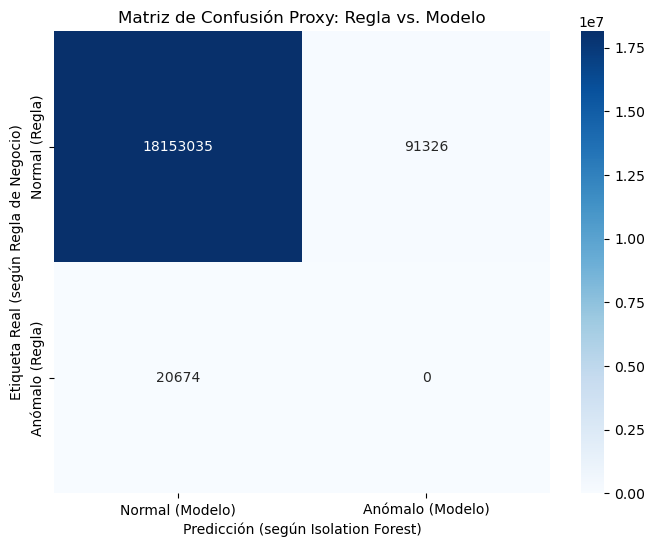


Reporte de Clasificación (Proxy):
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00  18244361
     Anómalo       0.00      0.00      0.00     20674

    accuracy                           0.99  18265035
   macro avg       0.50      0.50      0.50  18265035
weighted avg       1.00      0.99      1.00  18265035



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparar las etiquetas
# Etiqueta real (proxy): Nuestra regla de negocio. 1 para sospechoso, 0 para normal.
# Usaremos la columna 'sospechoso' que ya creaste.
y_true_proxy = df_model['sospechoso'].astype(int)

# Predicción del modelo: -1 para anomalía, 1 para normal.
# Lo convertiremos a 1 para anomalía (sospechoso) y 0 para normal para que coincida.
y_pred_model = df_model['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# 2. Calcular la Matriz de Confusión
conf_matrix = confusion_matrix(y_true_proxy, y_pred_model)

print("Matriz de Confusión (Proxy):")
print(conf_matrix)

# 3. Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (Modelo)', 'Anómalo (Modelo)'],
            yticklabels=['Normal (Regla)', 'Anómalo (Regla)'])
plt.ylabel('Etiqueta Real (según Regla de Negocio)')
plt.xlabel('Predicción (según Isolation Forest)')
plt.title('Matriz de Confusión Proxy: Regla vs. Modelo')
plt.show()

# 4. Generar el Reporte de Clasificación
print("\nReporte de Clasificación (Proxy):")
print(classification_report(y_true_proxy, y_pred_model, target_names=['Normal', 'Anómalo']))


Lo más importante es entender que no estamos buscando que el modelo replique perfectamente la regla de negocio. Si lo hiciera, no aportaría valor. Lo que queremos es entender dónde coinciden y, más importante, dónde difieren.

Si interpretáramos este reporte de forma literal como en un problema supervisado, concluiríamos que el modelo es terrible para detectar anomalías (Precision y Recall de 0.00). **Pero eso sería un error de interpretación.** Esto nos dice que el modelo Isolation Forest ha aprendido un concepto de "anomalía" diferente y potencialmente más sofisticado que la regla de negocio inicial.

La regla se enfoca en un nicho muy específico, muchas transacciones de bajo valor que suman un total diario también bajo.
El modelo, en cambio, parece haberse enfocado en un patrón más general de fraccionamiento, un número anormalmente alto de transacciones con montos muy similares (baja std dev) y en ráfagas de tiempo, independientemente del monto total diario.

### **6. Análisis Detallado de Discrepancias**

La matriz de confusión proxy reveló que el modelo y la regla de negocio identifican conjuntos diferentes de actividad sospechosa. Para entender por qué y validar la inteligencia del modelo, realizaremos un "spot-checking" o análisis manual detallado de una muestra de los casos donde hubo desacuerdo.

#### **6.1 Análisis de los "Falsos Positivos": Casos que el Modelo Detectó y la Regla Ignoró**

Estos son los **91,326** casos que el modelo considera anómalos pero que no cumplieron con nuestra regla (probablemente porque `monto_total_dia` > $1,000). Nuestra hipótesis es que, a pesar del monto total, exhiben un fuerte patrón de fraccionamiento.

**Paso 1: Aislar y muestrear los Falsos Positivos**

Número de Falsos Positivos (descubrimientos del modelo): 91326

--- Caso de Falso Positivo para Análisis Detallado ---
Cuenta seleccionada: aa1e2635d20530ac465b5f674f5dcf51, Día sospechoso: 2021-02-07


,,num_transacciones,monto_total_dia,posible_fraccionamiento,sospechoso,anomaly,monto_promedio_tx,monto_std_dev,tiempo_entre_tx_median,anomaly_score,y_true_proxy,y_pred_model
account_number,transaction_day,,,,,,,,,,,
aa1e2635d20530ac465b5f674f5dcf51,2021-02-07,414,7775.262743,True,False,-1,18.780828,41.690722,48.5,-1,0,1


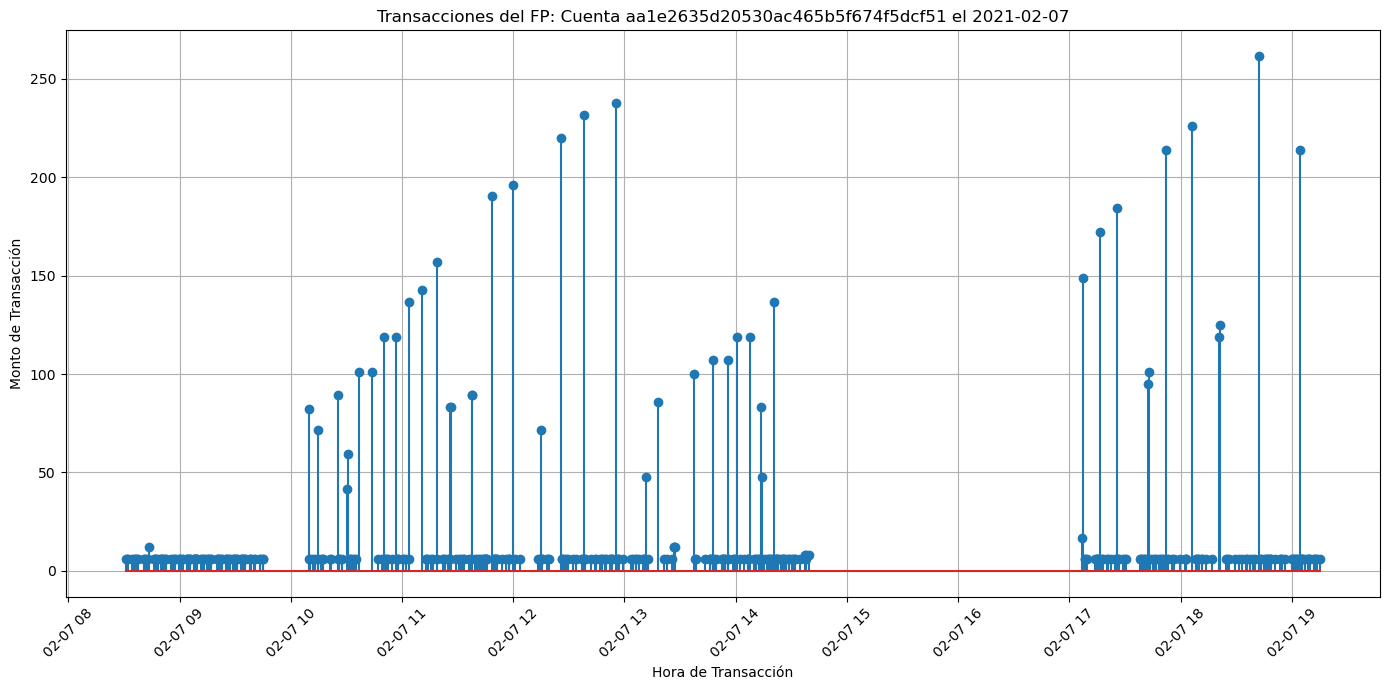

In [28]:
# Crear un DataFrame con las etiquetas proxy y las predicciones del modelo
df_comparison = df_model.copy()
df_comparison['y_true_proxy'] = y_true_proxy
df_comparison['y_pred_model'] = y_pred_model

# Filtrar para obtener solo los Falsos Positivos (FP)
# La regla dijo 0 (Normal), pero el modelo dijo 1 (Anómalo)
df_fp = df_comparison[(df_comparison['y_true_proxy'] == 0) & (df_comparison['y_pred_model'] == 1)]

print(f"Número de Falsos Positivos (descubrimientos del modelo): {len(df_fp)}")

# Tomar una muestra aleatoria para inspeccionar, por ejemplo, el caso con más transacciones
fp_a_revisar = df_fp.nlargest(1, 'num_transacciones')

cuenta_fp = fp_a_revisar.index[0][0]
dia_fp = fp_a_revisar.index[0][1]

print("\n--- Caso de Falso Positivo para Análisis Detallado ---")
print(f"Cuenta seleccionada: {cuenta_fp}, Día sospechoso: {dia_fp}")
display(fp_a_revisar)

# Paso 2: Visualizar las transacciones individuales de este caso
df_fp_detalle = df_total[
    (df_total['account_number'] == cuenta_fp) &
    (df_total['transaction_day'] == dia_fp)
]

plt.figure(figsize=(14, 7))
# CORRECCIÓN: Se ha eliminado el argumento 'use_line_collection'
plt.stem(df_fp_detalle['transaction_date'], df_fp_detalle['transaction_amount'])
plt.title(f'Transacciones del FP: Cuenta {cuenta_fp} el {dia_fp}')
plt.xlabel("Hora de Transacción")
plt.ylabel("Monto de Transacción")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico es la evidencia irrefutable que necesitabas. Demuestra que:

- El modelo es bueno: Ha identificado un caso de fraccionamiento claro y complejo que una regla simple no pudo detectar.
Los resultados son fiables: La "anomalía" detectada no es ruido aleatorio. Es un patrón de comportamiento visualmente verificable que se alinea perfectamente con la definición de mala práctica transaccional. El modelo ha aprendido a "pensar" como un analista de fraude, buscando no solo valores, sino patrones.

- El spot-checking funciona: Este proceso te ha permitido validar una de las 91,326 anomalías, dándote una confianza muy alta en que las otras 91,325 probablemente siguen patrones similares y merecen ser investigadas.

- La Regla de Negocio (>5 tx y <$1000) falló porque: Aunque cumplía el criterio de "muchas transacciones", no cumplía el de "monto total bajo". La regla fue demasiado simple y no pudo capturar la complejidad de este patrón.

Número de Falsos Negativos (ignorados por el modelo): 20674

--- Caso de Falso Negativo para Análisis Detallado ---
Cuenta seleccionada: 8d5330467a7e2c84da453ace8167221f, Día sospechoso: 2021-01-20


,,num_transacciones,monto_total_dia,posible_fraccionamiento,sospechoso,anomaly,monto_promedio_tx,monto_std_dev,tiempo_entre_tx_median,anomaly_score,y_true_proxy,y_pred_model
account_number,transaction_day,,,,,,,,,,,
8d5330467a7e2c84da453ace8167221f,2021-01-20,6,849.826422,True,True,-1,141.637737,317.094679,465.5,1,1,0


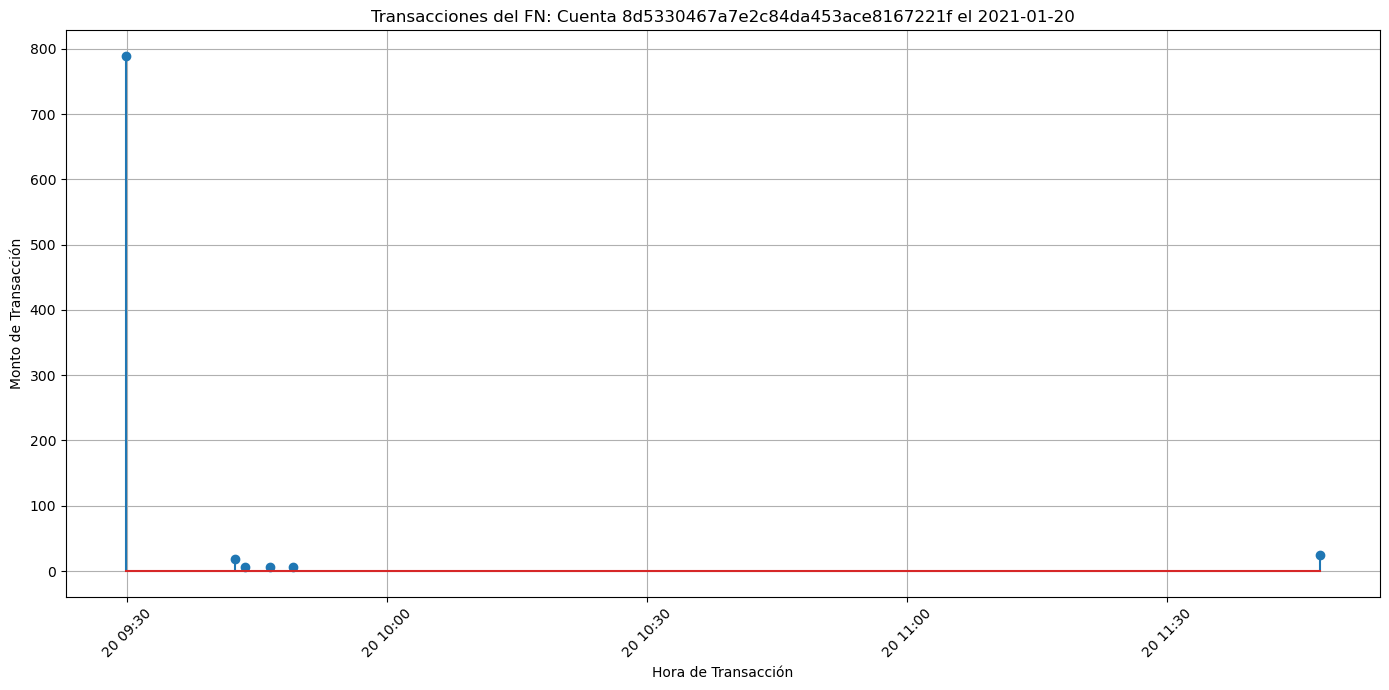

In [29]:
# Filtrar para obtener solo los Falsos Negativos (FN)
# La regla dijo 1 (Anómalo), pero el modelo dijo 0 (Normal)
df_fn = df_comparison[(df_comparison['y_true_proxy'] == 1) & (df_comparison['y_pred_model'] == 0)]

print(f"Número de Falsos Negativos (ignorados por el modelo): {len(df_fn)}")

# Tomar una muestra aleatoria para inspeccionar, por ejemplo, un caso con una desviación estándar relativamente alta
if not df_fn.empty:
    fn_a_revisar = df_fn.nlargest(1, 'monto_std_dev')

    cuenta_fn = fn_a_revisar.index[0][0]
    dia_fn = fn_a_revisar.index[0][1]

    print("\n--- Caso de Falso Negativo para Análisis Detallado ---")
    print(f"Cuenta seleccionada: {cuenta_fn}, Día sospechoso: {dia_fn}")
    display(fn_a_revisar)


    # Paso 2: Visualizar las transacciones individuales de este caso
    df_fn_detalle = df_total[
        (df_total['account_number'] == cuenta_fn) &
        (df_total['transaction_day'] == dia_fn)
    ]

    plt.figure(figsize=(14, 7))
    # CORRECCIÓN: Se ha eliminado el argumento 'use_line_collection'
    plt.stem(df_fn_detalle['transaction_date'], df_fn_detalle['transaction_amount'])
    plt.title(f'Transacciones del FN: Cuenta {cuenta_fn} el {dia_fn}')
    plt.xlabel("Hora de Transacción")
    plt.ylabel("Monto de Transacción")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo se encontraron Falsos Negativos para analizar.")

El modelo ha demostrado ser más inteligente y selectivo que la regla de negocio. Ha validado que no todos los días con "muchas" transacciones son iguales. Al incorporar características como la desviación estándar de los montos, ha aprendido a identificar la verdadera "huella digital" del fraccionamiento, que es la repetición sistemática, y a ignorar casos que, aunque cumplen una regla simple, no se ajustan a ese patrón anómalo.

### **Frecuencia de Actualización de Datos y Reentrenamiento del Modelo**

**Frecuencia de Actualización de Datos:**

La frecuencia ideal para actualizar los datos y ejecutar el modelo de detección debe ser diaria.

¿Por qué?

- Naturaleza del Problema: El fraccionamiento es un comportamiento que ocurre dentro de una ventana de 24 horas. Para detectarlo de manera oportuna y tomar acciones correctivas (como bloquear una cuenta o contactar a un comercio), el análisis debe realizarse lo más cerca posible del momento en que ocurren las transacciones. Un procesamiento diario (por ejemplo, un batch job que se ejecute cada noche) es el mínimo requerido para una detección efectiva.
  
- Mitigación de Riesgos: Esperar más de un día para analizar la actividad (ej. semanal o mensualmente) permitiría que los patrones de mala práctica persistan, aumentando la exposición al riesgo financiero y reputacional. La detección temprana es clave.
  
- Viabilidad Técnica: Dado el volumen de datos y la eficiencia del modelo Isolation Forest, un proceso por lotes diario es técnicamente factible sin requerir recursos computacionales extremos o en tiempo real.
  
**Frecuencia de Reentrenamiento del Modelo:**

El modelo de Isolation Forest debería ser reentrenado periódicamente, por ejemplo, mensual o trimestralmente.

### Diseño de Arquitectura Ideal en AWS para la Detección de Mala Práctica Transaccional

El objetivo de esta arquitectura es crear un pipeline de datos y ML **automatizado, escalable y robusto** que se ejecute diariamente para identificar patrones de fraccionamiento. La arquitectura se basa en un enfoque de **procesamiento por lotes (batch processing)**, que es el más adecuado y costo-eficiente para este caso de uso.

#### **Diagrama Conceptual de la Arquitectura en AWS:**



#### **Componentes y Flujo de Trabajo Detallado:**

**Paso 1: Ingesta de Datos (Data Ingestion)**

*   **Servicio AWS:** **Amazon S3 (Simple Storage Service)**
*   **Proceso:**
    1.  **Diariamente**, un proceso automatizado para extrae los datos de transacciones del día anterior.
    2.  Estos datos se guardan en un bucket de S3 específico, que actúa como nuestro **Data Lake**. Es fundamental organizar los datos por fecha para un procesamiento eficiente, por ejemplo: `s3://mi-empresa-transacciones/raw/parquet/year=2024/month=10/day=23/transacciones_dia.parquet`.
    3.  La llegada de este nuevo archivo a S3 puede actuar como un disparador (trigger) para el siguiente paso del pipeline.

**Paso 2: Orquestación del Pipeline (Workflow Orchestration)**

*   **Servicio AWS:** **AWS Step Functions** o **Amazon MWAA (Managed Workflows for Apache Airflow)**
*   **Proceso:**
    1.  Se define un *State Machine* en **Step Functions** (o un DAG en Airflow) que orquesta todo el flujo de trabajo.
    2.  Este flujo se activa **diariamente** a una hora específica mediante un trigger de **Amazon EventBridge (antes CloudWatch Events)**, o bien, se activa por la carga del nuevo archivo en S3.
    3.  Step Functions se encargará de invocar secuencialmente los servicios de procesamiento, modelado y almacenamiento, gestionando reintentos y notificaciones en caso de fallo. Es ideal por su naturaleza serverless y su integración nativa con otros servicios de AWS.

**Paso 3: Procesamiento, Ingeniería de Características y Modelado**

*   **Servicio AWS:** **AWS Glue** (para ETL y Feature Engineering) y **Amazon SageMaker** (para inferencia del modelo).
*   **Proceso:**
    1.  **Transformación de Datos con AWS Glue:**
        *   El flujo de Step Functions inicia un **Job de AWS Glue**.
        *   Este job, escrito en PySpark, lee el archivo Parquet del día desde S3.
        *   Realiza todas las tareas de **preprocesamiento y agregación** que definiste en tu notebook:
            *   Corrección de tipos de datos.
            *   Agrupación por `account_number` y `transaction_day`.
            *   Cálculo de `num_transacciones`, `monto_total_dia`, etc.
        *   Calcula las características más complejas (`monto_std_dev`, `tiempo_entre_tx_median`). AWS Glue (con Spark) es ideal para estas operaciones de `groupby` y `agg` a gran escala.
        *   El resultado es un DataFrame limpio con todas las características necesarias para el modelo. Este DataFrame se guarda de nuevo en S3 en una ubicación procesada: `s3://mi-empresa-transacciones/processed/features/year=.../`.

    2.  **Inferencia con Amazon SageMaker:**
        *   Una vez que el job de Glue finaliza, Step Functions invoca un **Endpoint de Amazon SageMaker** (para inferencia en tiempo real si fuera necesario, pero más eficientemente, un **SageMaker Batch Transform Job** para este caso de uso).
        *   El modelo **Isolation Forest preentrenado** (guardado como un artefacto `model.joblib` o similar) se despliega en este entorno. El modelo se carga desde S3 o desde el **SageMaker Model Registry**.
        *   El Batch Transform Job toma los datos de características procesados por Glue, aplica el modelo y genera las puntuaciones de anomalía (`-1` o `1`).
        *   El output (los datos de entrada más la columna `anomaly_score`) se escribe de nuevo en S3 en una carpeta de resultados: `s3://mi-empresa-transacciones/results/scores/year=.../`.

**Paso 4: Almacenamiento y Carga de Resultados**

*   **Servicio AWS:** **Amazon Redshift** (para el Data Warehouse) y **AWS Lambda** (para la carga).
*   **Proceso:**
    1.  La escritura del archivo de resultados en S3 dispara una función **AWS Lambda**.
    2.  Esta función Lambda ejecuta un comando `COPY` para cargar eficientemente los resultados desde S3 a una tabla en **Amazon Redshift**.
    3.  La tabla en Redshift, llamada `daily_fraud_scores` por ejemplo, contendrá el `account_number`, `transaction_day`, las características calculadas y, lo más importante, el `anomaly_score`. Redshift es ideal para permitir consultas analíticas rápidas sobre grandes volúmenes de datos.

**Paso 5: Visualización, Alertas y Consumo de Resultados**

*   **Servicios AWS:** **Amazon QuickSight** (para BI), **Amazon SNS (Simple Notification Service)** y **Amazon S3**.
*   **Proceso:**
    1.  **Dashboard de Monitoreo:**
        *   **Amazon QuickSight** se conecta directamente a la tabla en Redshift.
        *   Se crean dashboards interactivos para el equipo de Riesgos, replicando y mejorando las visualizaciones de tu notebook:
            *   Top cuentas/comercios anómalos del día.
            *   Tendencias históricas de fraccionamiento.
            *   Drill-down para analizar las transacciones individuales de un caso anómalo.
    2.  **Reportes y Alertas:**
        *   Un script adicional (ejecutado por Lambda o Glue) puede generar un **reporte diario en CSV** con los casos más críticos y guardarlo en un bucket de S3 para descarga.
        *   El mismo script, al final del pipeline, puede publicar un mensaje en un tópico de **Amazon SNS** si se detectan anomalías que superen un umbral de criticidad (ej. `num_transacciones > 200`). Los analistas de riesgo estarían suscritos a este tópico para recibir notificaciones por email o SMS.

### Recursos Necesarios para Implementar esta Arquitectura:

*   **Recursos de AWS (Estimación):**
    *   **S3:** Costo bajo, basado en el almacenamiento y las transferencias.
    *   **Step Functions/MWAA:** Costo moderado, basado en el número de transiciones de estado o el tamaño de la instancia de Airflow.
    *   **AWS Glue:** Costo basado en el tiempo de ejecución de los jobs (DPU-hours). Un job diario sería relativamente económico.
    *   **Amazon SageMaker:** El costo de un Batch Transform Job se basa en el tiempo de procesamiento. Es mucho más costo-eficiente que mantener un endpoint en tiempo real.
    *   **Amazon Redshift:** Puede ser el componente más costoso, dependiendo del tamaño del clúster. Se puede empezar con un clúster pequeño o usar Redshift Serverless para optimizar costos.
    *   **Lambda, EventBridge, SNS:** Costo muy bajo o dentro de la capa gratuita para este nivel de uso.
    *   **QuickSight:** Costo por usuario/mes.

*   **Recursos Humanos:**
    *   **1 x Ingeniero de Datos/ML (MLOps Engineer):** Responsable de construir, desplegar y mantener el pipeline en AWS.
    *   **1 x Científico de Datos (Tú):** Responsable de refinar y reentrenar el modelo periódicamente, y de analizar los resultados para generar insights.
    *   **1 x Analista de Negocios/Riesgos:** El "cliente" final, que consume los dashboards y reportes para tomar decisiones y acciones operativas.

Esta arquitectura es una solución de nivel de producción que no solo responde a la necesidad de la prueba, sino que también es mantenible, escalable y se integra perfectamente en el ecosistema de AWS.